In [1]:
### for file IO:
import os
work_dir = os.getcwd()

import codecs
from sklearn.externals import joblib # for pickling the pipeline

### for data analysis:
import numpy as np
import pandas as pd

### for text cleaning & preprocessing:
import re
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

### for plotting:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

### for vectorizing text & training ML algorithms:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib # for pickling the pipeline

from __future__ import print_function # use print as a function like in python3

In [4]:
stop = stopwords.words("english")

def rmURL(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    return tweet

def rmMARK(tweet):
    tweet = rmURL(tweet)
    #Convert @username to ATusername
    tweet = re.sub('@','AT',tweet)
    #Replace # with HASH_TAG
    tweet = re.sub('#', 'HASH', tweet)
    #Temporarily store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
    #Remove all non-word charactersand add the emoticons to 
    # the end of the processed document string
    # remove emoticon nose to be consistent
    tweet = re.sub('[\W]+', ' ', tweet) + ' ' + ' '.join(emoticons).replace('-', '')
    #trim
    tweet = tweet.strip('\'"')
    return tweet

def tweetCleaner(tweet):
    tweet = rmURL(tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Replace # with HASH_TAG
    tweet = re.sub('#', 'HASH_TAG ', tweet)
    #Temporarily store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
    #Remove all non-word charactersand add the emoticons to 
    # the end of the processed document string
    # remove emoticon nose to be consistent
    tweet = re.sub('[\W]+', ' ', tweet) + ' ' + ' '.join(emoticons).replace('-', '')
    #trim
    tweet = tweet.strip('\'"')
    return tweet

def rmURLtokenizer(tweet):
    tweet = rmURL(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

def rmMARKtokenizer(tweet):
    tweet = rmMARK(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

def tweetTokenizer(tweet):
    tweet = tweetCleaner(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

porter = PorterStemmer()
def rmURL_porter(text):
    return [porter.stem(word) for word in rmURLtokenizer(text)]

def rmMARK_porter(text):
    return [porter.stem(word) for word in rmMARKtokenizer(text)]

def tokenizer_porter(text):
    return [porter.stem(word) for word in tweetTokenizer(text)]

## Load in the pickled data frame:

In [5]:
df = pd.read_pickle('healthcare_RTbinary_pandasDF.pkl')

In [6]:
pos = df.ix[df['RTbinary'] == 1]

neg = df.ix[df['RTbinary'] == 0]

In [7]:
negtrain = neg.sample(n = pos.shape[0],random_state=0)
negtest = neg.drop(negtrain.index)

In [8]:
df = pos.append(negtrain)

In [9]:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [10]:
df.head()

,RTbinary,tweet
608892,True,RT @IESHealthcare: Pursue a career in emergenc...
33185,False,"Want to work in #Jacksonville, FL? View our la..."
358323,False,"""Earn attractive honorarium by taking medical ..."
373739,True,"RT @carrollu: Welcome to @Donn_DimondPT '98, o..."
348749,True,I don't want the NHS to spend its time on immi...


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.tweet.values, df.RTbinary.values,
                                                   train_size = 0.8, random_state = 0)


In [51]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

param_grid = [
    {'vect__ngram_range': [(1,2),(1,3)],
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [rmURLtokenizer, rmMARKtokenizer, tweetTokenizer, 
                         rmURL_porter, rmMARK_porter, tokenizer_porter],
     'clf__n_estimators': [100, 200],
     'clf__min_samples_leaf': [30, 300, 3000],
     'clf__oob_score':[False]},
    {'vect__ngram_range': [(1,2),(1,3)],
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [rmURLtokenizer, rmMARKtokenizer, tweetTokenizer, 
                         rmURL_porter, rmMARK_porter, tokenizer_porter],
     'vect__use_idf':[False],
     'vect__norm':[None],
     'clf__n_estimators': [100, 200],
     'clf__min_samples_leaf': [30, 300, 3000],
     'clf__oob_score':[False]}
]

lr_tfidf = Pipeline([ ('vect', tfidf), ('clf', RandomForestClassifier(random_state=0)) ])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy',
                           cv=5, verbose=1, n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 103.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 183.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 289.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 337.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'clf__oob_score': [False], 'clf__min_samples_leaf': [30, 300, 3000], 'vect__tokenizer': [<function rmURLtokenizer at 0x10ad8dea0>, <function rmMARKtokenizer at 0x149875d08>, <function tweetTokenizer at 0x149904f28>, <function rmURL_porter at 0x149904ea0>, <function rmMARK_porter at 0x14...sn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'], None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

# Load the pickled classifier here

In [1]:
#Uncomment the text below to load the classifier
gs_lr_tfidf = joblib.load('gridcv_RF_subsample.pkl')

NameError: name 'joblib' is not defined

In [25]:
print('Best parameter set: %s' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

pct = float(sum(y_test))/len(y_test)
print('Random Chance Accuracy in Test Set: %.3f' % pct)


Best parameter set: {'clf__min_samples_leaf': 300, 'vect__tokenizer': <function tokenizer_porter at 0x10b81c8c8>, 'clf__n_estimators': 200, 'vect__use_idf': False, 'vect__ngram_range': (1, 2), 'clf__oob_score': False, 'vect__stop_words': None, 'vect__norm': None}
CV Accuracy: 0.781
Test Accuracy: 0.848
Random Chance Accuracy in Test Set: 0.182


In [29]:
y_pred = clf.predict(X_test)

In [27]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title, fontsize = 18)
    plt.colorbar()
    tick_marks = [0,1] 
    plt.xticks(tick_marks, fontsize = 14) 
    plt.yticks(tick_marks, fontsize = 14) 
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize = 16)
    plt.xlabel('Predicted Labels', fontsize= 16)

In [30]:
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)

Normalized confusion matrix
[[ 0.84  0.16]
 [ 0.09  0.91]]


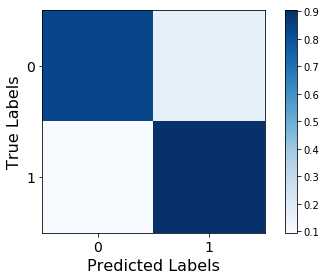

In [31]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
img = 'normCM.png'
plt.tight_layout()

In [32]:
cls_report = classification_report(y_test, y_pred, labels)
print(cls_report)

             precision    recall  f1-score   support

          0       0.98      0.84      0.90       619
          1       0.55      0.91      0.68       138

avg / total       0.90      0.85      0.86       757



In [70]:
test_all_X = np.append(X_test,neg.tweet.values)

In [72]:
test_all_y = np.append(y_test,neg.RTbinary.values)
print (len(test_all_y),len(test_all_X))

287891 287891


In [73]:
print (sum(test_all_y))

5824


In [75]:
y_pred_all = clf.predict(test_all_X)

In [76]:
cm_all = confusion_matrix(test_all_y,y_pred_all,labels)
cls_report_all = classification_report(test_all_y,y_pred_all,labels)

Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.27  0.73]]


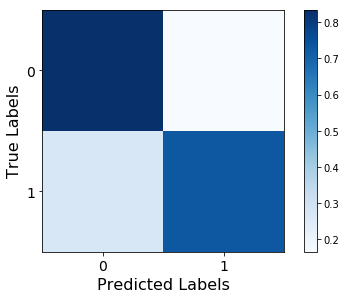

In [77]:
cm_normalized_all = cm_all.astype('float') / cm_all.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
print('Normalized confusion matrix')
print(cm_normalized_all)
plt.figure()
plot_confusion_matrix(cm_normalized_all, title='Normalized confusion matrix')
img = 'normCM.png'

In [78]:
print (cls_report_all)

             precision    recall  f1-score   support

          0       0.99      0.83      0.91    282067
          1       0.08      0.73      0.15      5824

avg / total       0.97      0.83      0.89    287891



In [62]:
joblib.dump(clf,'classifier_RF_subsample.pkl',compress = 1)

['classifier_RF_subsample.pkl']

In [65]:
joblib.dump(gs_lr_tfidf,'gridcv_RF_subsample.pkl',compress = 1)

['gridcv_RF_subsample.pkl']